In [1]:
import os
import random
import logging
from copy import deepcopy
from collections import defaultdict
from matplotlib import pyplot as plt

import cv2
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader

from isegm.utils.log import logger, TqdmToLogger, SummaryWriterAvg
from isegm.utils.vis import draw_probmap, draw_points, add_tag
from isegm.utils.misc import save_checkpoint
from isegm.utils.serialization import get_config_repr
from isegm.utils.distributed import get_dp_wrapper, get_sampler, reduce_loss_dict
from torch.cuda.amp import autocast as autocast, GradScaler

from isegm.utils.exp_imports.default import * 

MODEL_NAME = "lidc_hrnet32"

from isegm.data.compose import ComposeDataset, ProportionalComposeDataset
import torch.nn as nn
from isegm.data.aligned_augmentation import AlignedAugmentator

from isegm.data.compose import ComposeDataset, ProportionalComposeDataset
import torch.nn as nn
from isegm.data.aligned_augmentation import AlignedAugmentator, ProbabilisticAlignedAugmentator
from isegm.data.preprocess import Preprocessor
from albumentations import Compose, PadIfNeeded, RandomCrop, RGBShift, RandomBrightnessContrast

In [2]:
device = torch.device('cuda:0')

In [3]:
LIDC_PATH = "/gpfs/space/projects/PerkinElmer/donatasv_experiments/datasets/processed_datasets/LIDC-2D/train"
LIDC_VAL_PATH = "/gpfs/space/projects/PerkinElmer/donatasv_experiments/datasets/processed_datasets/LIDC-2D/val"
# LIDC_CROPS_PATH = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/datasets/processed_datasets/LIDC-2D-128-CROPS/Tr'
# LIDC_PATH = "/gpfs/space/projects/PerkinElmer/donatasv_experiments/datasets/processed_datasets/LIDC-2D-FULL/train"
# LIDC_VAL_PATH = "/gpfs/space/projects/PerkinElmer/donatasv_experiments/datasets/processed_datasets/LIDC-2D-FULL/val"

In [4]:
def visualise_raw_batch(batch):
    fig, ax = plt.subplots(2, 3, figsize=(25, 10))
    plt.close()
    
    image = batch['images'][:, :1, :, :]
    
    ax[0, 0].set_title("Image")
    ax[0, 0].imshow(image[0, 0, :, :], cmap='gray')
    ax[0, 0].contour(batch['instances'][0, 0, :, :], colors='lime', linewidths=0.5)
    points = batch['points'][0]
    half_point = points.shape[0] // 2
    pos_points = points[:half_point]
    neg_points = points[half_point:]
    pos_points = [point for point in pos_points if point[0] != -1]
    neg_points = [point for point in neg_points if point[0] != -1]
    ax[0, 0].scatter([point[1] for point in pos_points], [point[0] for point in pos_points], c='lime', s=5)
    ax[0, 0].scatter([point[1] for point in neg_points], [point[0] for point in neg_points], c='red', s=5)
    
    instances = batch['instances'][:, :1, :, :]
    
    ax[0, 1].set_title("Mask")
    ax[0, 1].imshow(instances[0, 0, :, :])
    # ax[0, 1].imshow(make_grid(instances, nrow=2))
    
    ax[0, 2].set_title("Trimap")
    ax[0, 2].imshow(batch['trimap'][0, 0, :, :])
    
    ax[1, 0].set_title(f'Image focus, roi: {batch["rois"][0]}')
    ax[1, 0].imshow(batch['images_focus'][0, 0, :, :], cmap='gray')
    
    # focus_points = batch['points_focus'][0]
    # half_point = focus_points.shape[0] // 2
    # pos_points = focus_points[:half_point]
    # neg_points = focus_points[half_point:]
    # pos_points = [point for point in pos_points if point[0] != -1]
    # neg_points = [point for point in neg_points if point[0] != -1]
    # ax[1, 0].scatter([point[0] for point in pos_points], [point[1] for point in pos_points], c='lime', s=5)
    # ax[1, 0].scatter([point[0] for point in neg_points], [point[1] for point in neg_points], c='red', s=5)
    
    ax[1, 1].set_title('Mask focus')
    ax[1, 1].imshow(batch['instances_focus'][0, 0, :, :])
    
    ax[1, 2].set_title('Trimap focus')
    ax[1, 2].imshow(batch['trimap_focus'][0, 0, :, :])
    
    return fig

In [5]:
import matplotlib.pyplot as plt

def visualise_batch_images(batch):
    num_images = batch['images'].shape[0]  # Number of images in the batch
    fig, ax = plt.subplots(num_images, 2, figsize=(9, 4 * num_images))  # Adjust subplot grid
    plt.close()

    for i in range(num_images):
        # Process each image in the batch
        image = batch['images'][i, :1, :, :]
        instances = batch['instances'][i, :1, :, :]
        points = batch['points'][i]
        half_point = points.shape[0] // 2
        pos_points = [point for point in points[:half_point] if point[0] != -1]
        neg_points = [point for point in points[half_point:] if point[0] != -1]

        # Display image
        ax[i, 0].set_title(f"Image {i+1}")
        ax[i, 0].imshow(image[0, :, :], cmap='gray')
        ax[i, 0].contour(instances[0, :, :], colors='lime', linewidths=0.5)
        ax[i, 0].scatter([point[1] for point in pos_points], [point[0] for point in pos_points], c='lime', s=5)
        ax[i, 0].scatter([point[1] for point in neg_points], [point[0] for point in neg_points], c='red', s=5)

        # Display mask
        ax[i, 1].set_title(f"Mask {i+1}")
        ax[i, 1].imshow(instances[0, :, :])

    return fig


In [6]:

points_sampler = MultiPointSampler(
        20,
        prob_gamma=0.80,
        merge_objects_prob=0.15,
        max_num_merged_objects=2,
        use_hierarchy=False,
        first_click_center=True,
    )

# preprocessor = Preprocessor()
# preprocessor.normalize = True
# preprocessor.convert_to_rgb = False
preprocessor = Preprocessor()
preprocessor.normalize = True
preprocessor.windowing = True
preprocessor.window_min = -900
preprocessor.window_max = 600
preprocessor.num_input_channels = 1


train_set = LidcDataset(
    LIDC_PATH, points_sampler=points_sampler, preprocessor=preprocessor
)

# train_set = LidcCropsDataset(
#     LIDC_CROPS_PATH, points_sampler=points_sampler, preprocessor=preprocessor
# )

val_set = LidcDataset(
    LIDC_VAL_PATH, points_sampler=points_sampler, preprocessor=preprocessor
)

# target_crop_size = (
#     256,256
# )
# train_augmentator = ProbabilisticAlignedAugmentator(
#     ratio=[
#         0.06,
#         0.176,
#     ],
#     target_size=target_crop_size,
#     crop_probability=0.8,
#     flip=True,
#     distribution='Gaussian',
#     gs_center=1,
# )

# from albumentations import Compose, RandomCrop, PadIfNeeded, HorizontalFlip,  IAAAffine, ElasticTransform

# crop_size = (320, 480)

# train_augmentator = Compose(
#             [
#                 UniformRandomResize(scale_range=(0.75, 1.40)),
#                 HorizontalFlip(),
#                 # VerticalFlip(),
#                 IAAAffine(rotate=(-45, 45), mode='constant'),  # Rotation
                
#                 # RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),  # Brightness/Contrast adjustments
                
#                 # GaussNoise(var_limit=(5, 15)),  # Gaussian Noise
#                 ElasticTransform(alpha=1, sigma=25, alpha_affine=25),  # Elastic Deformation
                
#                 PadIfNeeded(
#                     min_height=crop_size[0], min_width=crop_size[1], border_mode=0
#                 ),
#                 RandomCrop(*crop_size),
                
#             ],
#             p=1.0,
#         )

# train_set.augmentator = train_augmentator

In [7]:
train_data = DataLoader(
    train_set,
    4,
    sampler=get_sampler(train_set, shuffle=False, distributed=False),
    drop_last=False,
    pin_memory=True,
    num_workers=0
)
val_data = DataLoader(
    val_set,
    8,
    sampler=get_sampler(val_set, shuffle=False, distributed=False),
    drop_last=False,
    pin_memory=True,
    num_workers=0,
)

In [8]:
train_iter = iter(train_data)
val_iter = iter(val_data)

val_batch = next(val_iter)
# val_batch = next(val_iter)
# val_batch = next(val_iter)
# val_batch = next(val_iter)

train_batch = next(train_iter)

In [13]:
focus_rois = train_batch['rois']
focus_rois

tensor([[114., 184., 168., 230.],
        [131., 117., 172., 166.],
        [173., 359., 205., 391.],
        [232., 127., 264., 159.]])

In [14]:
bboxes = torch.chunk(focus_rois, focus_rois.shape[0], dim=0)
bboxes

(tensor([[114., 184., 168., 230.]]),
 tensor([[131., 117., 172., 166.]]),
 tensor([[173., 359., 205., 391.]]),
 tensor([[232., 127., 264., 159.]]))

In [19]:
h, w = train_batch['images'].shape[2:]
h, w

(512, 512)

In [23]:
x1 = focus_rois[:, 0]
y1 = focus_rois[:, 1]
x2 = focus_rois[:, 2]
y2 = focus_rois[:, 3]

In [24]:
hc, wc = y2 - y1, x2 - x1
hc, wc

(tensor([46., 49., 32., 32.]), tensor([54., 41., 32., 32.]))

In [26]:
ry, rx = h / hc, w / wc
ry, rx

(tensor([11.1304, 10.4490, 16.0000, 16.0000]),
 tensor([ 9.4815, 12.4878, 16.0000, 16.0000]))

In [37]:
bias = torch.stack([y1, x1, torch.zeros_like(y1), torch.zeros_like(y1)], dim=1)
bias

tensor([[184., 114.,   0.,   0.],
        [117., 131.,   0.,   0.],
        [359., 173.,   0.,   0.],
        [127., 232.,   0.,   0.]])

In [39]:
ratio = torch.stack([ry, rx, torch.ones_like(ry), torch.ones_like(ry)], dim=1)
ratio

tensor([[11.1304,  9.4815,  1.0000,  1.0000],
        [10.4490, 12.4878,  1.0000,  1.0000],
        [16.0000, 16.0000,  1.0000,  1.0000],
        [16.0000, 16.0000,  1.0000,  1.0000]])

In [41]:
points = train_batch['points']
points

tensor([[[196., 138.,   0.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.,  -1.,   5.],
         [ -1.,  -1.

In [43]:
points.shape

torch.Size([4, 40, 4])

In [44]:
bias = bias.unsqueeze(1)
ratio = ratio.unsqueeze(1)
bias.shape, ratio.shape

(torch.Size([4, 1, 4]), torch.Size([4, 1, 4]))

In [47]:
points_focus = (points - bias) * ratio
points_focus[0][:5]

tensor([[ 1.3357e+02,  2.2756e+02,  0.0000e+00,  5.0000e+00],
        [-2.0591e+03, -1.0904e+03, -1.0000e+00,  5.0000e+00],
        [-2.0591e+03, -1.0904e+03, -1.0000e+00,  5.0000e+00],
        [-2.0591e+03, -1.0904e+03, -1.0000e+00,  5.0000e+00],
        [-2.0591e+03, -1.0904e+03, -1.0000e+00,  5.0000e+00]])

In [ ]:
visualise_raw_batch(train_batch)

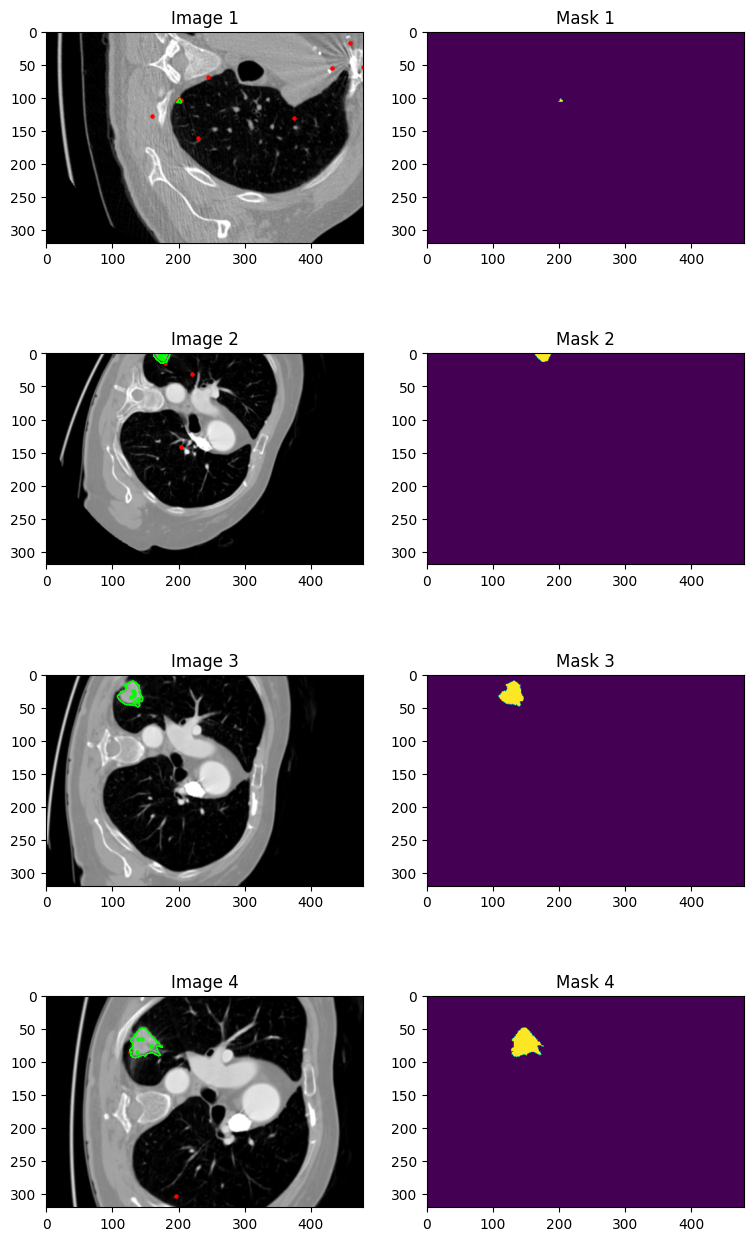

In [12]:
visualise_batch_images(train_batch)

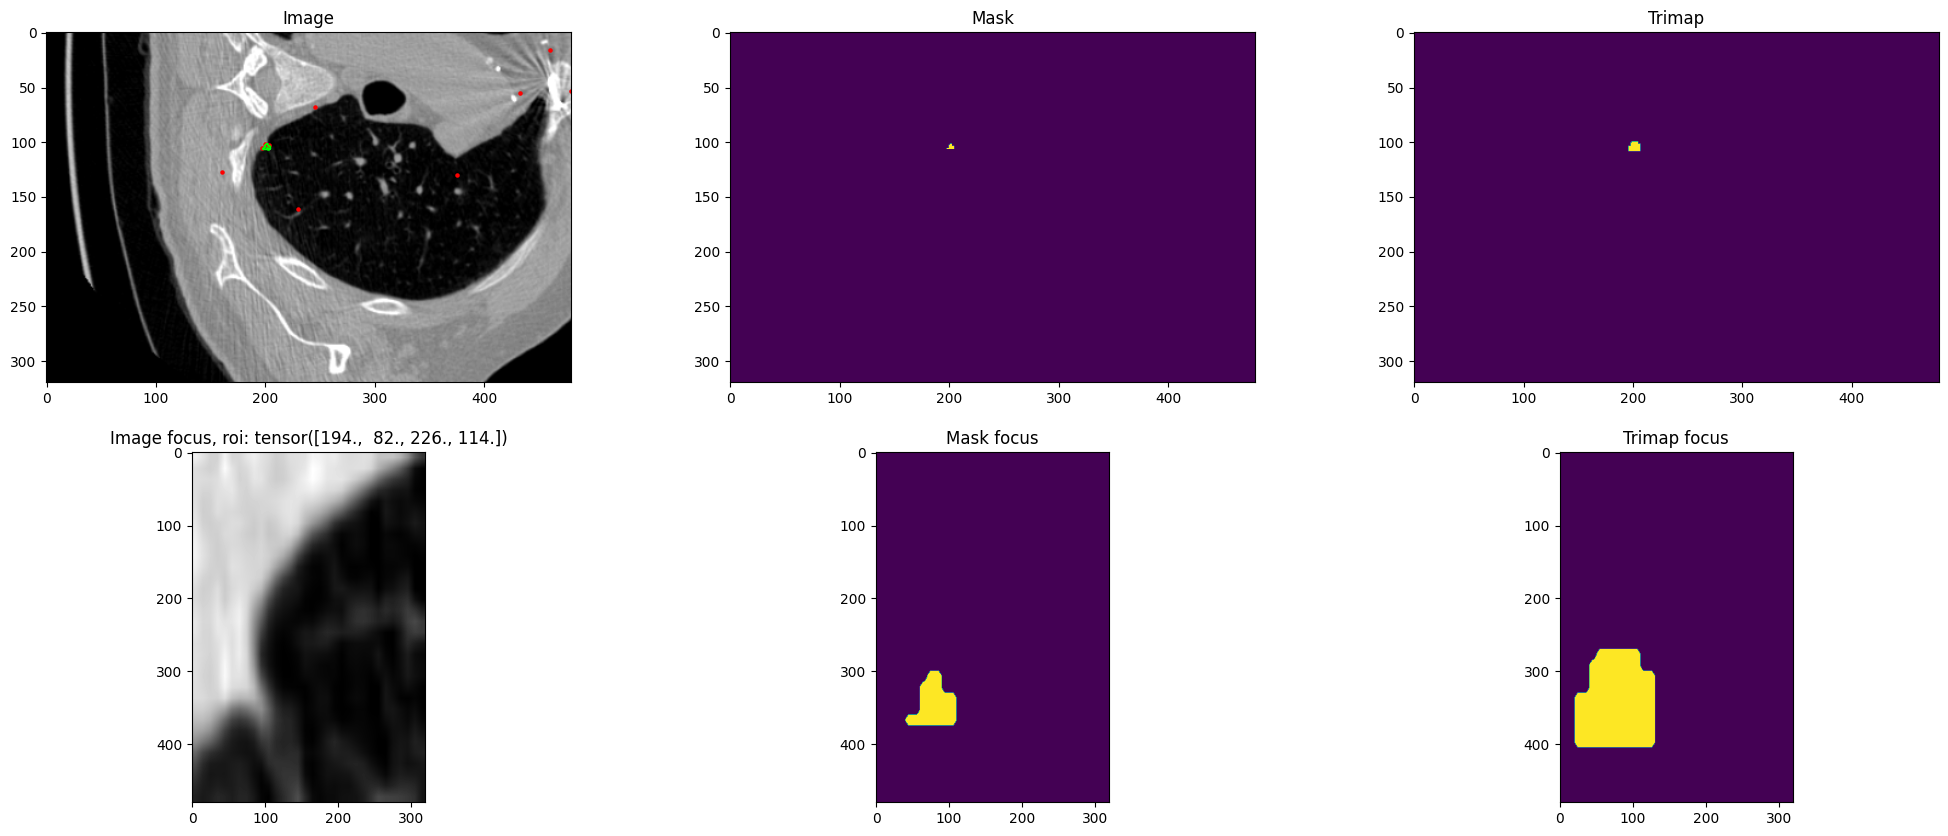

In [13]:
visualise_raw_batch(train_batch)

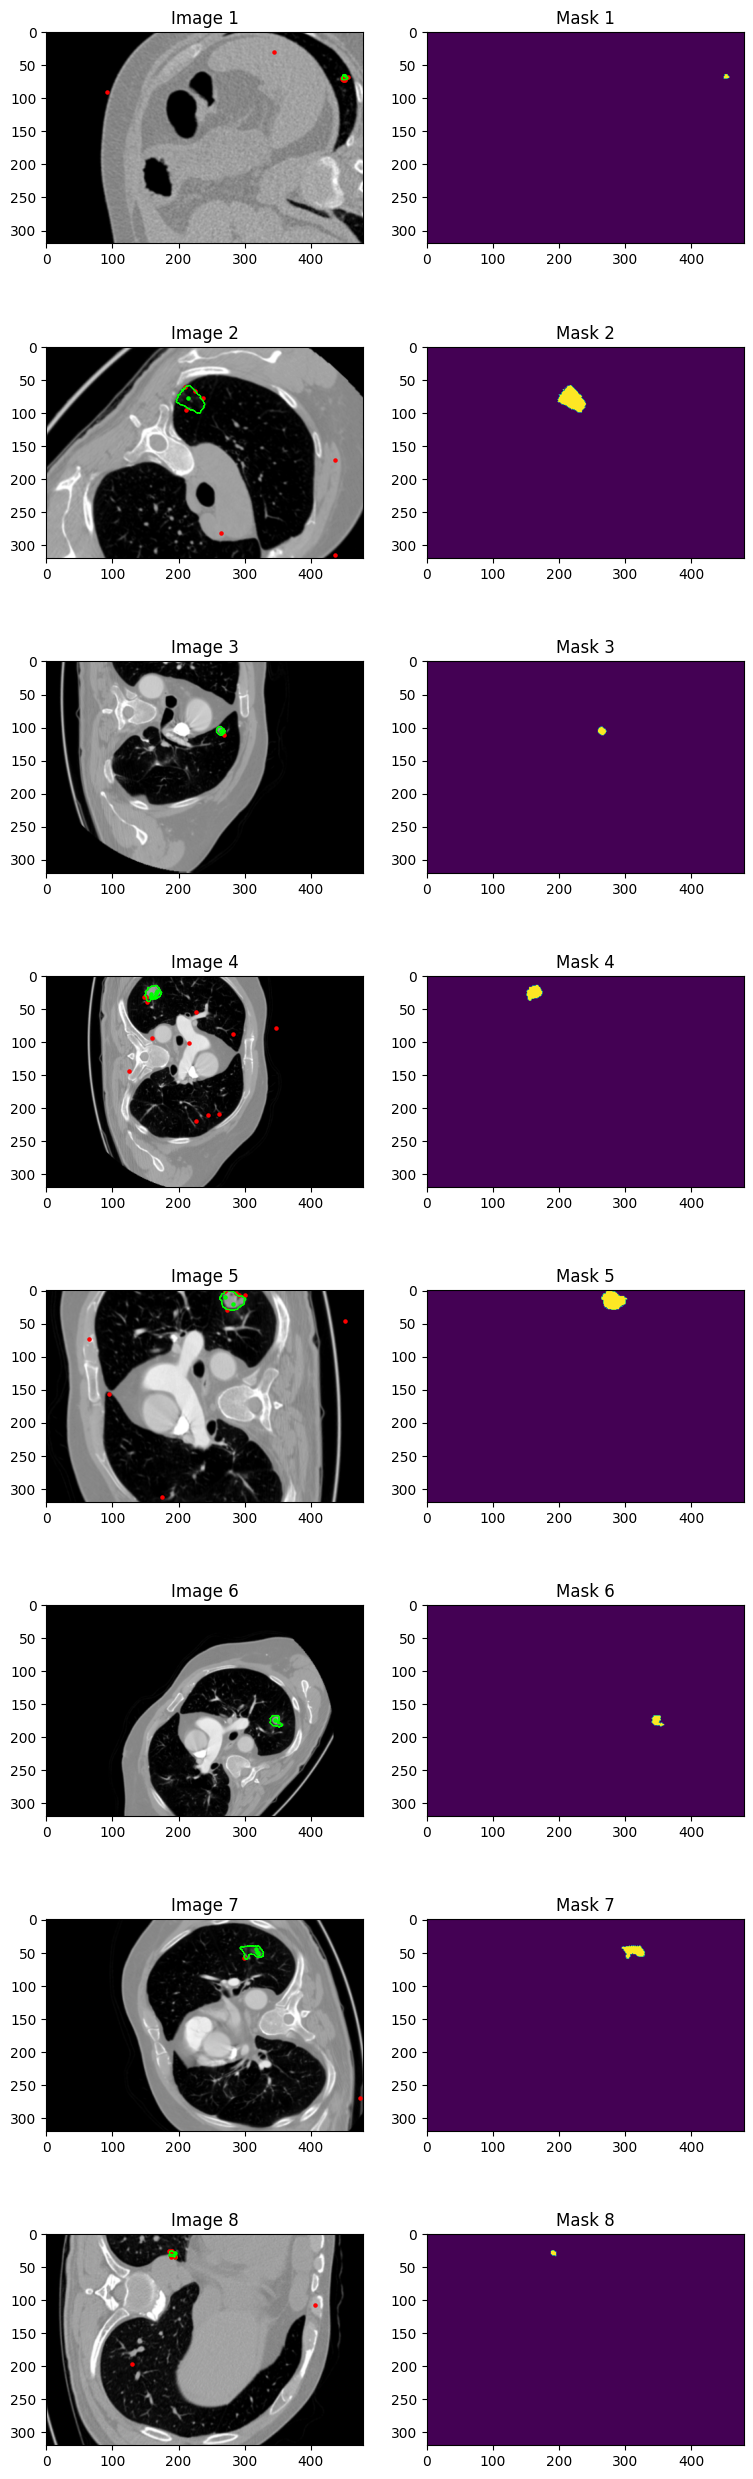

In [14]:
visualise_batch_images(val_batch)

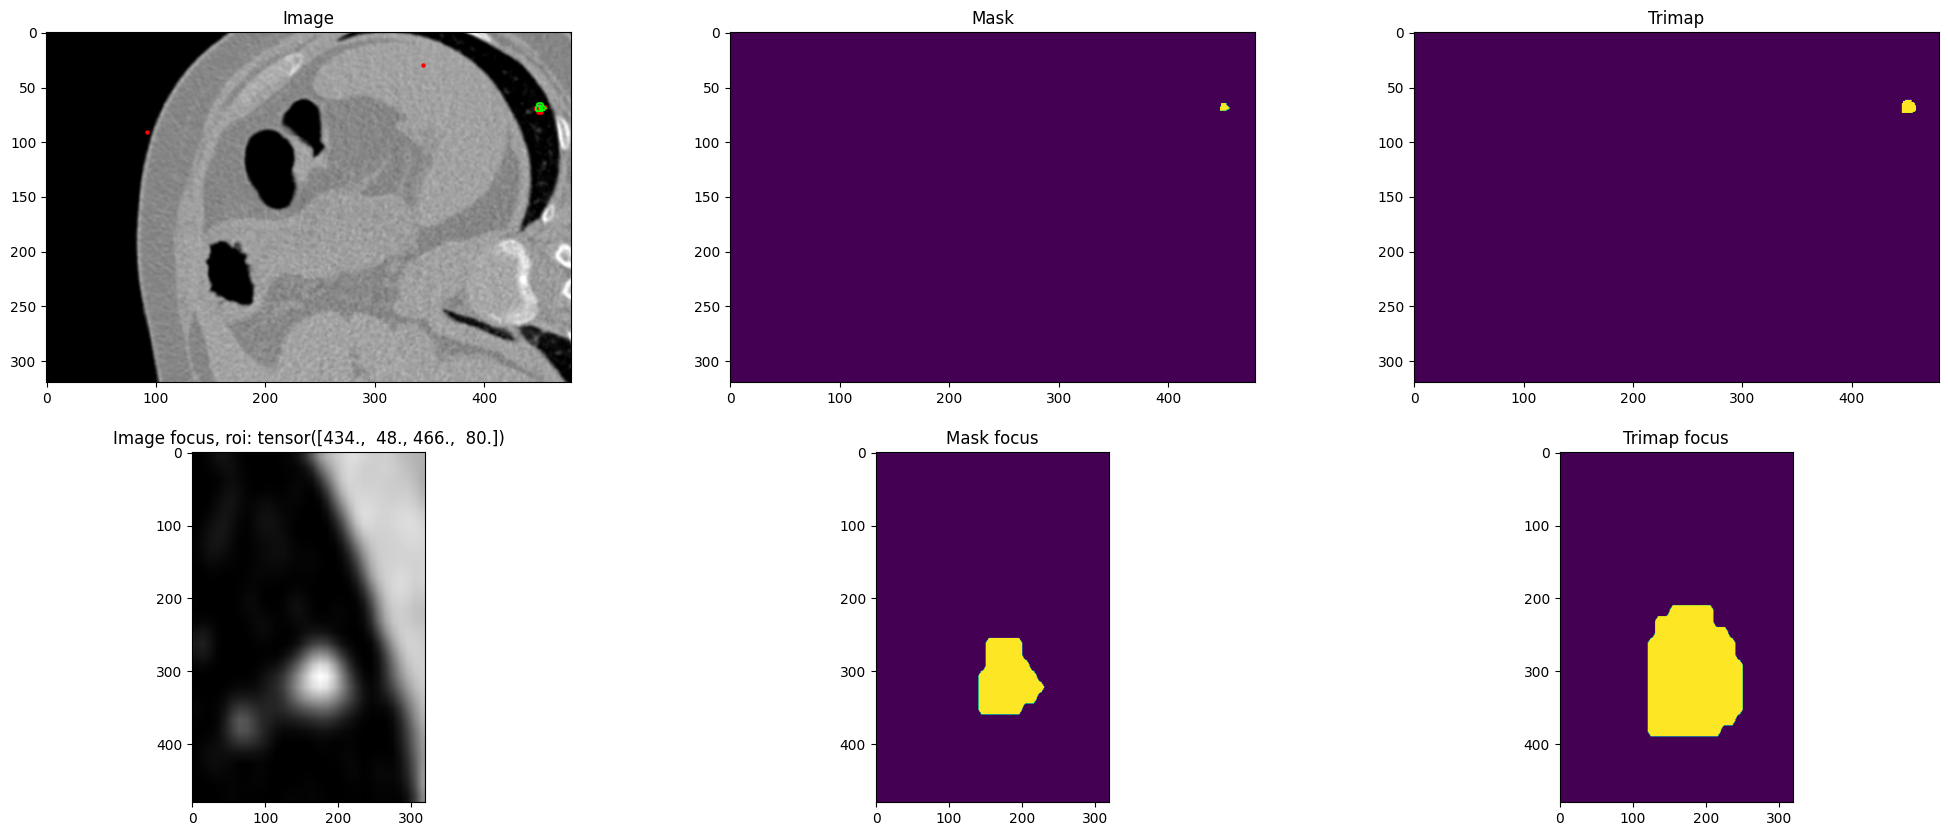

In [15]:
visualise_raw_batch(val_batch)

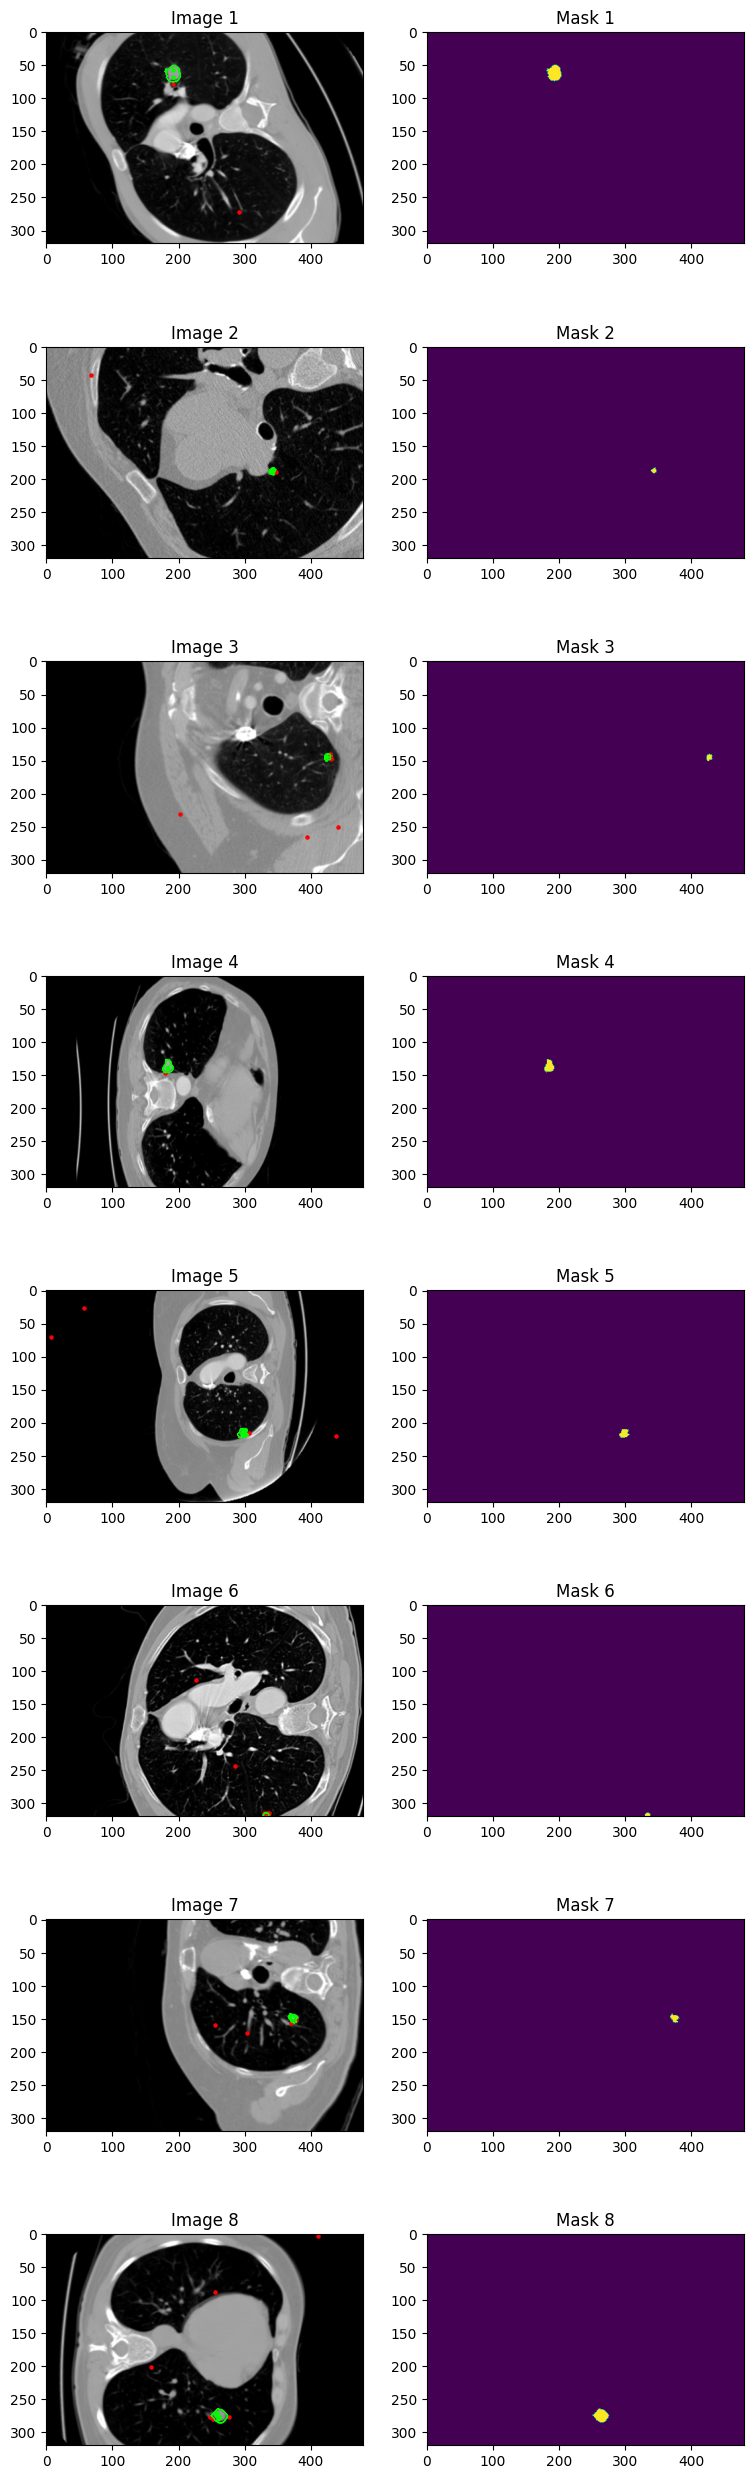

In [128]:
# visualise_raw_batch(val_batch)
visualise_batch_images(val_batch)

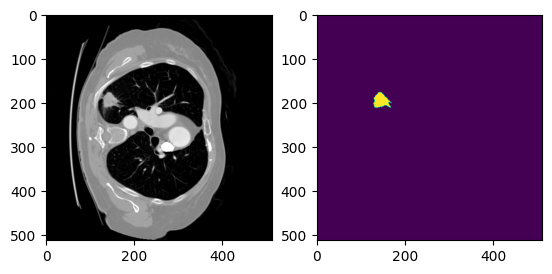

In [11]:
train_sample = train_set.get_sample(0)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(train_sample.image[:,:,0], cmap='gray')
ax[1].imshow(train_sample.gt_mask)

# Train imitation

In [12]:
loss_cfg = edict()
loss_cfg.instance_loss = NormalizedFocalLossSigmoid(alpha=0.5, gamma=2)
loss_cfg.instance_loss_weight = 1.0
loss_cfg.instance_aux_loss = SigmoidBinaryCrossEntropyLoss()
loss_cfg.instance_aux_loss_weight = 0.4
loss_cfg.instance_refine_loss = WFNL(alpha=0.5, gamma=2)
loss_cfg.instance_refine_loss_weight = 1.0
loss_cfg.trimap_loss = nn.BCEWithLogitsLoss()
loss_cfg.trimap_loss_weight = 1.0

In [13]:
def add_loss(loss_name, total_loss, losses_logging, validation, lambda_loss_inputs
    ):
        loss_weight = loss_cfg.get(loss_name + '_weight', 0.0)
        if loss_weight > 0.0:
            loss_criterion = loss_cfg.get(loss_name)
            loss = loss_criterion(*lambda_loss_inputs())
            loss = torch.mean(loss)
            losses_logging[loss_name] = loss
            loss = loss_weight * loss
            total_loss = total_loss + loss

        return total_loss

In [14]:
def get_next_points_removeall(
    pred, gt, points, points_focus, rois, click_indx, pred_thresh=0.49, remove_prob=0.0
):
    assert click_indx > 0
    pred = pred.cpu().numpy()[:, 0, :, :]
    gt = gt.cpu().numpy()[:, 0, :, :] > 0.5
    rois = rois.cpu().numpy()
    h, w = gt.shape[-2], gt.shape[-1]

    fn_mask = np.logical_and(gt, pred < pred_thresh)
    fp_mask = np.logical_and(np.logical_not(gt), pred > pred_thresh)

    fn_mask = np.pad(fn_mask, ((0, 0), (1, 1), (1, 1)), 'constant').astype(np.uint8)
    fp_mask = np.pad(fp_mask, ((0, 0), (1, 1), (1, 1)), 'constant').astype(np.uint8)
    num_points = points.size(1) // 2
    points = points.clone()

    for bindx in range(fn_mask.shape[0]):
        fn_mask_dt = cv2.distanceTransform(fn_mask[bindx], cv2.DIST_L2, 5)[1:-1, 1:-1]
        fp_mask_dt = cv2.distanceTransform(fp_mask[bindx], cv2.DIST_L2, 5)[1:-1, 1:-1]

        fn_max_dist = np.max(fn_mask_dt)
        fp_max_dist = np.max(fp_mask_dt)

        is_positive = fn_max_dist > fp_max_dist
        dt = fn_mask_dt if is_positive else fp_mask_dt
        inner_mask = dt > max(fn_max_dist, fp_max_dist) / 2.0
        indices = np.argwhere(inner_mask)
        if len(indices) > 0:
            coords = indices[np.random.randint(0, len(indices))]
            if np.random.rand() < remove_prob:
                points[bindx] = points[bindx] * 0.0 - 1.0
            if is_positive:
                points[bindx, num_points - click_indx, 0] = float(coords[0])
                points[bindx, num_points - click_indx, 1] = float(coords[1])
                points[bindx, num_points - click_indx, 2] = float(click_indx)
            else:
                points[bindx, 2 * num_points - click_indx, 0] = float(coords[0])
                points[bindx, 2 * num_points - click_indx, 1] = float(coords[1])
                points[bindx, 2 * num_points - click_indx, 2] = float(click_indx)

        x1, y1, x2, y2 = rois[bindx]
        point_focus = points[bindx]
        hc, wc = y2 - y1, x2 - x1
        ry, rx = h / hc, w / wc
        bias = torch.tensor([y1, x1, 0]).to(points.device)
        ratio = torch.tensor([ry, rx, 1]).to(points.device)
        points_focus[bindx] = (point_focus - bias) * ratio
    return points, points_focus

In [15]:
MAX_NUM_NEXT_CLICKS = 0

In [16]:
from isegm.inference import utils
from isegm.utils import exp

device = torch.device('cuda:0')
cfg = exp.load_config_file('config.yml', return_edict=True)

In [17]:
# checkpoint_path = find_checkpoint(
#     # cfg.INTERACTIVE_MODELS_PATH, 'pretrained_fullres_final'
#     cfg.INTERACTIVE_MODELS_PATH, 'author_pretrained_combined'
# )

TRAINING_OUTPUT_PATH = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/training'

checkpoint_path = utils.find_checkpoint_from_training(TRAINING_OUTPUT_PATH, 'focalclick_target_crop_aug')
print(checkpoint_path)

model = utils.load_is_model(checkpoint_path, 'cpu', model_type='FocalClick')

for param in model.parameters():
    param.requires_grad = True
model = model.to(device)
model.train()

click_models = None
prev_mask_drop_prob = 0.0

/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/training/2023-11-29/13-39-34-FocalClick-focalclick_target_crop_aug/checkpoints/best_model.pth
Model args: {'pipeline_version': 's2', 'width': 32, 'ocr_width': 128, 'small': False, 'with_aux_output': True, 'use_leaky_relu': True, 'use_rgb_conv': False, 'use_disks': True, 'norm_radius': 5, 'with_prev_mask': True, 'model_type': 'FocalClick'}
Property use_disks deprecated for DistMaps
Property use_disks deprecated for DistMaps


In [18]:
def batch_forward(
        batch_data,
        validation=False,
    ):
        
        losses_logging = dict()

        with torch.set_grad_enabled(not validation):
            batch_data = {k: v.to(device) for k, v in batch_data.items()}
            image, gt_mask, points = (
                batch_data['images'],
                batch_data['instances'],
                batch_data['points'],
            )
            print(points)
            points_focus = batch_data['points_focus']
            rois = batch_data['rois']
            orig_image, orig_gt_mask, orig_points = (
                image.clone(),
                gt_mask.clone(),
                points.clone(),
            )

            prev_output = torch.zeros_like(image, dtype=torch.float32)[:, :1, :, :]

            last_click_indx = None

            with torch.no_grad():
                num_iters = random.randint(0, MAX_NUM_NEXT_CLICKS)
                print(f'num_iters: {num_iters}')
                inference_info = []

                for click_indx in range(num_iters):
                    last_click_indx = click_indx

                    if not validation:
                        model.eval()

                    if click_models is None or click_indx >= len(
                        click_models
                    ):
                        eval_model = model
                    else:
                        eval_model = click_models[click_indx]

                    net_input = (
                        torch.cat((image, prev_output), dim=1)
                        if model.with_prev_mask
                        else image
                    )
                    
                    prev_mask = prev_output.cpu().clone()
                    
                    prev_output = torch.sigmoid(
                        eval_model(net_input, points)['instances']
                    )
                    
                    inference_info.append({
                        'image': image.cpu(),
                        'prev_mask': prev_mask.cpu(),
                        'points': points.cpu(),
                        'ouput': prev_output
                    })

                    points, points_focus = get_next_points_removeall(
                        prev_output,
                        orig_gt_mask,
                        points,
                        points_focus,
                        rois,
                        click_indx + 1,
                    )

                    if not validation:
                        model.train()
                        # for m in self.net.feature_extractor.modules():
                        #        m.eval()

                if (
                    model.with_prev_mask
                    and prev_mask_drop_prob > 0
                    and last_click_indx is not None
                ):
                    zero_mask = (
                        np.random.random(size=prev_output.size(0))
                        < prev_mask_drop_prob
                    )
                    prev_output[zero_mask] = torch.zeros_like(prev_output[zero_mask])


            batch_data['points'] = points
            batch_data['prev_mask'] = prev_output
            batch_data['points_focus'] = points_focus

            net_input = (
                torch.cat((image, prev_output), dim=1)
                if model.with_prev_mask
                else image
            )
            output = model(net_input, points)
            
            info = {
            }
            
            info['coarse_pass'] = {
                'inference_info': inference_info,
                'image': image.cpu(),
                'prev_mask': prev_output.cpu(),
                'points': points.cpu(),
                'points_focus': points_focus.cpu(),
                'output': output
            }

            # ====== refine =====
            images_focus, points_focus, rois = (
                batch_data['images_focus'],
                batch_data['points_focus'],
                batch_data['rois'],
            )
            full_feature, full_logits = output['feature'], output['instances']
            bboxes = torch.chunk(rois, rois.shape[0], dim=0)
            # print( len(bboxes), bboxes[0].shape, rois.shape  )
            refine_output = model.refine(
                images_focus, points_focus, full_feature, full_logits, bboxes
            )
            
            info['refine_pass'] = {
                'images_focus': images_focus.cpu(),
                'points_focus': points_focus.cpu(),
                'rois': rois.cpu(),
                'full_feature': full_feature.cpu(),
                'full_logits': full_logits.cpu(),
                'bboxes': bboxes,
                'refine_output': refine_output
            }

            loss = 0.0
            loss = add_loss(
                'instance_loss',
                loss,
                losses_logging,
                validation,
                lambda: (output['instances'], batch_data['instances']),
            )

            loss = add_loss(
                'instance_click_loss',
                loss,
                losses_logging,
                validation,
                lambda: (
                    output['instances'],
                    batch_data['instances'],
                    output['click_map'],
                ),
            )

            loss = add_loss(
                'instance_aux_loss',
                loss,
                losses_logging,
                validation,
                lambda: (output['instances_aux'], batch_data['instances']),
            )

            loss = add_loss(
                'trimap_loss',
                loss,
                losses_logging,
                validation,
                lambda: (refine_output['trimap'], batch_data['trimap_focus']),
            )

            loss = add_loss(
                'instance_refine_loss',
                loss,
                losses_logging,
                validation,
                lambda: (
                    refine_output['instances_refined'],
                    batch_data['instances_focus'],
                    batch_data['trimap_focus'],
                ),
            )

            # if self.is_master:
                # with torch.no_grad():
                #     for m in metrics:
                #         m.update(
                #             *(output.get(x) for x in m.pred_outputs),
                #             *(batch_data[x] for x in m.gt_outputs),
                #         )
        return (
            loss,
            losses_logging,
            batch_data,
            output,
            refine_output,
            info
        )

In [19]:
loss, losses_logging, batch_data, output, refine_output, run_info = batch_forward(train_batch)

tensor([[[185., 186.,   0.],
         [ -1.,  -1.,  -1.]],

        [[ 89., 244.,   0.],
         [ -1.,  -1.,  -1.]],

        [[161., 194.,   0.],
         [ -1.,  -1.,  -1.]],

        [[208.,  12.,   0.],
         [ -1.,  -1.,  -1.]]], device='cuda:0')
num_iters: 0


/gpfs/space/home/donatasv/.conda/envs/bcv_clickseg/lib/python3.7/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


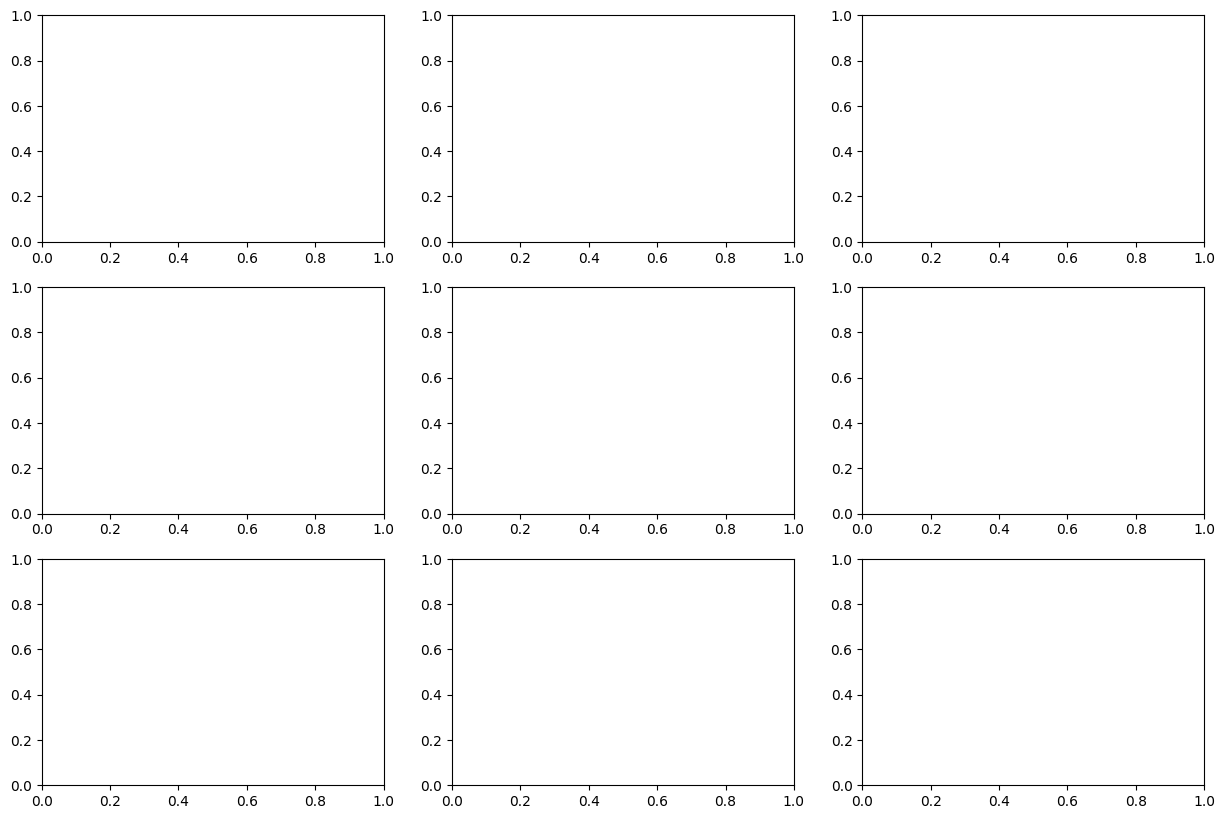

In [20]:
def visualise_coarse_iterations(info, indx=0):
    
    points = info['coarse_pass']['points'][indx].cpu().numpy()
    half_point = points.shape[0] // 2
    pos_points = points[:half_point]
    neg_points = points[half_point:]
    pos_points = [[point[0], point[1], point[2], True] for point in pos_points if point[0] != -1 and point[2] != 100]
    neg_points = [[point[0], point[1], point[2], False] for point in neg_points if point[0] != -1 and point[2] != 100]
    points = pos_points + neg_points
    points.sort(key=lambda x: x[2])
        
    info = info['coarse_pass']['inference_info']
    
    fig, ax = plt.subplots(3, 3, figsize=(15, 10))
    plt.close()
    
    for i, inf in enumerate(info):
        
        ax[i, 0].set_title("Image")
        ax[i, 0].imshow(inf['image'][indx, 0, :, :].cpu(), cmap='gray')
        ax[i, 0].axis('off')

        ax[i, 0].scatter([point[1] for point in points[:i+1] if point[3] == True], [point[0] for point in points[:i+1] if point[3] == True], c='lime', s=5)
        ax[i, 0].scatter([point[1] for point in points[:i+1] if point[3] == False], [point[0] for point in points[:i+1] if point[3] == False], c='red', s=5)

        ax[i,1].set_title("Previous prediction")
        ax[i,1].imshow(inf['prev_mask'][indx, 0, :, :].cpu())
        ax[i,1].axis('off')

        ax[i,2].set_title("Output prediction")
        ax[i,2].imshow(inf['ouput'][indx, 0, :, :].cpu().detach())
        ax[i,2].axis('off')
        
    return fig
    
visualise_coarse_iterations(run_info, indx=0)    

dict_keys(['inference_info', 'image', 'prev_mask', 'points', 'points_focus', 'output'])
dict_keys(['instances', 'instances_aux', 'feature', 'click_map'])
[]


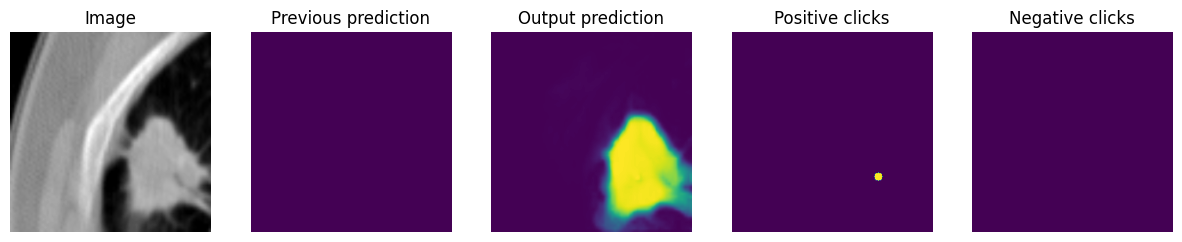

In [21]:
def visualise_coarse(info, indx=0):
    info = info['coarse_pass']
    print(info.keys())
    print(info['output'].keys())
    
    fig, ax = plt.subplots(1, 5, figsize=(15, 10))
    
    ax[0].set_title("Image")
    ax[0].imshow(info['image'][indx, 0, :, :].cpu(), cmap='gray')
    ax[0].axis('off')
    
    points = info['points'][indx].cpu().numpy()
    half_point = points.shape[0] // 2
    pos_points = points[:half_point]
    neg_points = points[half_point:]
    pos_points = [[point[0], point[1], point[2], True] for point in pos_points if point[0] != -1 and point[2] != 100]
    neg_points = [[point[0], point[1], point[2], False] for point in neg_points if point[0] != -1 and point[2] != 100]
    points = pos_points + neg_points
    points.sort(key=lambda x: x[2])
    points = points[:len(info['inference_info'])]
    
    ax[0].scatter([point[1] for point in points if point[3] == True], [point[0] for point in points if point[3] == True], c='lime', s=5)
    ax[0].scatter([point[1] for point in points if point[3] == False], [point[0] for point in points if point[3] == False], c='red', s=5)
    print(points)
    
    ax[1].set_title("Previous prediction")
    ax[1].imshow(info['prev_mask'][indx, 0, :, :].cpu())
    ax[1].axis('off')
    
    ax[2].set_title("Output prediction")
    ax[2].imshow(torch.sigmoid(info['output']['instances'][indx, 0, :, :].cpu().detach()))
    ax[2].axis('off')
    
    ax[3].set_title("Positive clicks")
    ax[3].imshow(info['output']['click_map'][indx, 0, :, :].cpu().detach())
    ax[3].axis('off')
    
    ax[4].set_title("Negative clicks")
    ax[4].imshow(info['output']['click_map'][indx, 1, :, :].cpu().detach())
    ax[4].axis('off')
    
visualise_coarse(run_info, indx=0)    

In [22]:
point_maps = model.dist_maps_base(run_info['coarse_pass']['image'][0:1],run_info['coarse_pass']['points'][0:1])

In [23]:
run_info['refine_pass'].keys()

dict_keys(['images_focus', 'points_focus', 'rois', 'full_feature', 'full_logits', 'bboxes', 'refine_output'])

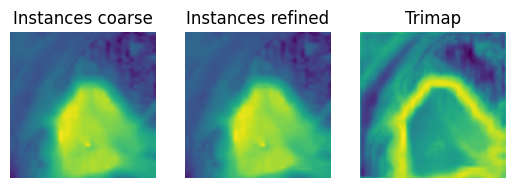

In [24]:
import matplotlib.pyplot as plt

def visualise_refine_iterations(info, indx=0):
    fig, ax = plt.subplots(1,3)  # Adjust the number of subplots based on the data
    plt.close()

    # Display refine_output
    ax[0].set_title("Instances coarse")
    ax[0].imshow(info['refine_output']['instances_coarse'][indx, 0].detach().cpu())
    ax[0].axis('off')
    
    ax[1].set_title("Instances refined")
    ax[1].imshow(info['refine_output']['instances_refined'][indx, 0].detach().cpu())
    ax[1].axis('off')
    
    ax[2].set_title("Trimap")
    ax[2].imshow(info['refine_output']['trimap'][indx, 0].detach().cpu())
    ax[2].axis('off')

    return fig

# Example usage
visualise_refine_iterations(run_info['refine_pass'], indx=0)
